# Municipality Analysis

In [1]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('nutritive.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

/home/localhost/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.property_type.unique()

array(['Casa', 'Otro', 'Lote', 'Finca', 'Oficina', 'Apartamento',
       'Parqueadero', 'Local comercial', 'Depósito', nan], dtype=object)

In [4]:
import re
from unicodedata import normalize
def cleanText(inputString):
    return (re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", inputString), 0, re.I
    )).lower()

def clean_l3(row):
    row.l3 = cleanText(row.l3)
    return row

def clean_alpha(inputString):
    return re.sub('[^A-Za-z0-9]+', '', inputString)

## Sell and Rent Counting

In [5]:
df = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df = df.apply(lambda x: clean_l3(x), axis=1)
df.shape

(613054, 25)

In [6]:
df_train = df.copy()
    
df_train = df_train[df_train['price']<df_train['price'].quantile(0.99)]
df_train = df_train[df_train['price'] > df_train['price'].quantile(0.1)]
df_train = df_train[df_train['surface_total'] > 0]
df_train = df_train[~np.isnan(df_train['price']) & df_train['price'] > 0]
df_train = df_train[df_train['surface_total'] > 0]

df_train['price'] = np.log(df_train['price'])

In [7]:
df_final = df_train.copy()

In [8]:
n = 10 #First n most frequent municipalities
series = df_train['l3'].value_counts()[:n]
municipalities = list(series.index)
freq = list(series)

In [9]:
df_balanced = pd.DataFrame(columns=list(df_train.columns))

In [10]:
#To make undersampling
n_under = min(freq) #Undersampling min number
df_final = df_train[df_train['l3'].isin(municipalities)]

for x in municipalities:
    temp_df = df_final[df_final['l3'] == x].sample(n = n_under, random_state=4)
    df_balanced = pd.concat([df_balanced, temp_df], ignore_index=True)
    

In [11]:
df_balanced.drop(columns=['id',"ad_type",'start_date', 'start_date','created_on','end_date',
                 'l1','l2', 'l4','l6', 'l5', 
                 'rooms', 'price_period', 'surface_covered',
                 'operation_type','currency', 'title', 'description'], inplace=True)

In [12]:
df_train = df_balanced.copy()

## Machine Learning - Initial Model

In [210]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             Y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [138]:
X_df = df_train.drop('price', axis=1).copy()
Y_df = df_train['price'].copy()

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(
    X_df, Y_df, test_size=0.2, random_state=5000)

In [141]:
# Para eliminar SettingWithCopyWarning

X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [142]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [143]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,l3,bedrooms,bathrooms,surface_total,property_type
64916,7.100000,-73.116997,bucaramanga,5.0,2.0,0.190543,Apartamento
20641,11.023675,-74.860947,barranquilla,NaN,3.0,-0.092228,Casa
29793,5.072902,-75.523653,manizales,4.0,2.0,0.861274,Casa
45451,7.893000,-72.488000,cucuta,2.0,2.0,-0.714284,Apartamento
62604,NaN,NaN,bucaramanga,4.0,4.0,0.768529,Apartamento


### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [144]:
# Categorical Class
print("Classes: ", X_train['property_type'].unique())
X_train.head()

Classes:  ['Apartamento' 'Casa' 'Lote' 'Finca' 'Otro' 'Parqueadero' 'Oficina'
 'Local comercial' 'Depósito']


,lat,lon,l3,bedrooms,bathrooms,surface_total,property_type
64916,7.100000,-73.116997,bucaramanga,5.0,2.0,0.190543,Apartamento
20641,11.023675,-74.860947,barranquilla,NaN,3.0,-0.092228,Casa
29793,5.072902,-75.523653,manizales,4.0,2.0,0.861274,Casa
45451,7.893000,-72.488000,cucuta,2.0,2.0,-0.714284,Apartamento
62604,NaN,NaN,bucaramanga,4.0,4.0,0.768529,Apartamento


In [145]:
le_l3 = LabelEncoder()
le_l3.fit(X_train['l3'])
X_train['l3'] = le_l3.transform(X_train['l3'])

In [146]:
ohe_l3 = OneHotEncoder()
ohe_l3.fit(X_train["l3"].values[:,None])
out = ohe_l3.transform(X_train["l3"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_l3.categories_[0]:
    current_class = le_l3.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("l3", axis =1)

In [147]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [148]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op2 = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op2.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

### Tratamiento de datos faltantes o NaN

In [149]:
from sklearn.impute import SimpleImputer

In [150]:
# Using Simple Imputer
si_bedrooms = SimpleImputer(strategy='mean')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='mean')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='mean')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='mean')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

In [151]:
#Otras transformaciones
cols2scale = ['bedrooms', 'bathrooms']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,op_barranquilla,op_bogota d.c,op_bucaramanga,op_cali,op_cartagena,...,op_pereira,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
64916,7.100000,-73.116997,1.013676e+00,-0.605380,0.190543,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20641,11.023675,-74.860947,5.776931e-16,0.134606,-0.092228,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29793,5.072902,-75.523653,3.632511e-01,-0.605380,0.861274,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45451,7.893000,-72.488000,-9.375981e-01,-0.605380,-0.714284,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62604,6.747057,-74.861314,3.632511e-01,0.874593,0.768529,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [153]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [154]:
X_test['l3'] = le_l3.transform(X_test['l3'])

In [155]:
temp_test = ohe_l3.transform(X_test["l3"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()

for idx, col in enumerate(ohe_cols_op2):
    X_test[col] = temp_test[:,idx]
    
    


X_test = X_test.drop("property_type", axis=1)
X_test = X_test.drop("l3", axis=1)

In [156]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [157]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [158]:
assert (X_test.columns.values == X_train.columns.values).all()

In [159]:
X_train

,lat,lon,bedrooms,bathrooms,surface_total,op_barranquilla,op_bogota d.c,op_bucaramanga,op_cali,op_cartagena,...,op_pereira,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
64916,7.100000,-73.116997,1.013676e+00,-0.605380,0.190543,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20641,11.023675,-74.860947,5.776931e-16,0.134606,-0.092228,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29793,5.072902,-75.523653,3.632511e-01,-0.605380,0.861274,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45451,7.893000,-72.488000,-9.375981e-01,-0.605380,-0.714284,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62604,6.747057,-74.861314,3.632511e-01,0.874593,0.768529,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64898,7.092000,-73.111000,-2.871735e-01,-0.605380,-0.284716,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64641,7.120000,-73.112000,-2.871735e-01,0.134606,-0.339826,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55905,4.812486,-75.669839,5.776931e-16,-0.605380,-0.992690,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34242,5.065670,-75.519837,5.776931e-16,-1.345367,-0.476691,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [160]:
#Rename columns
new_col = []

for col in list(X_train.columns):
    new_col.append(clean_alpha(col))
    
    
X_train.columns = new_col
X_test.columns = new_col

# Bagging

In [205]:
from sklearn.ensemble import BaggingRegressor
model2 = sklearn.ensemble.BaggingRegressor(n_estimators = 2000, max_samples = 20, max_features = 24)
model2.fit(X_train, Y_train)

prediction2 = model2.predict(X_test)
score = model2.score(X_test, Y_test)

score

0.5532436858032954

## Bagging with ExtraTree

In [161]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
extra_tree = ExtraTreeRegressor(splitter = "best" ,random_state=1000)
lin_reg = BaggingRegressor(extra_tree, random_state=1000, n_estimators=40)
lin_reg.fit(X_train, Y_train)

BaggingRegressor(base_estimator=ExtraTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   random_state=1000,
                                                   splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=40, n_jobs=Non

In [162]:
Y_test_estimate = lin_reg.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse = mean_squared_error(Y_test, Y_test_estimate)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))
r2 = r2_score(Y_test, Y_test_estimate)
print("R^2 = {:.3f}".format(r2))

Root Mean Square Error (RMSE)= 0.13
Mean Absolute Error (MAE)= 0.23
R^2 = 0.796


In [163]:
#### cross validation of model

from sklearn.model_selection import  cross_val_score, KFold
kfold = KFold(n_splits=5)
results = cross_val_score(lin_reg, X_train, Y_train, cv=kfold)
print("Efectividad en la validacion : ", results,"\n Promedio de Efectividad predicciones : ", round(np.mean(results), 3))

Efectividad en la validacion :  [0.78400488 0.79390953 0.77865046 0.78608114 0.78864625] 
 Promedio de Efectividad predicciones :  0.786


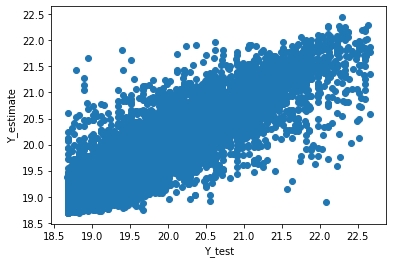

In [164]:
plt.scatter(Y_test, Y_test_estimate)
plt.xlabel("Y_test")
plt.ylabel("Y_estimate")
plt.show()

## Lasso Regression

In [220]:
import sklearn
from sklearn.linear_model import  LassoCV, Lasso
from sklearn.model_selection import  GridSearchCV

model = sklearn.linear_model.Lasso(alpha = 0.1)
model.fit(X_train, Y_train)
print(model.coef_)
print(model.intercept_)
prediction = model.predict(X_test)
score_ = model.score(X_test, Y_test)  

score_

[ 0.         -0.         -0.          0.16393221  0.32502982 -0.
  0.         -0.         -0.          0.         -0.          0.
 -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.          0.          0.        ]
19.81495640726964


0.4555708225091387

In [223]:
## Grid Search
param_grid = { 'alpha': [i/100 for i in range(1,20)]}
#model_ = GridSearchCV(estimator= model, param_grid= param_grid, n_jobs=-1)
#model_.fit(X_train, Y_train)
#model_.best_score_
#model_.score(X_test, Y_test)       

## LightGBM

In [171]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error

print('Loading data...')
# load or create your dataset
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=6000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10000)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(Y_test, y_pred))

Loading data...
Starting training...
[1]	valid_0's l2: 0.593991	valid_0's l1: 0.612691
Training until validation scores don't improve for 10000 rounds
[2]	valid_0's l2: 0.568551	valid_0's l1: 0.597564
[3]	valid_0's l2: 0.535755	valid_0's l1: 0.578763
[4]	valid_0's l2: 0.514493	valid_0's l1: 0.5655
[5]	valid_0's l2: 0.486734	valid_0's l1: 0.548673
[6]	valid_0's l2: 0.468866	valid_0's l1: 0.536889
[7]	valid_0's l2: 0.445283	valid_0's l1: 0.521699
[8]	valid_0's l2: 0.436067	valid_0's l1: 0.515563
[9]	valid_0's l2: 0.415116	valid_0's l1: 0.501821
[10]	valid_0's l2: 0.395994	valid_0's l1: 0.488815
[11]	valid_0's l2: 0.378424	valid_0's l1: 0.476578
[12]	valid_0's l2: 0.363238	valid_0's l1: 0.465684
[13]	valid_0's l2: 0.349229	valid_0's l1: 0.45541
[14]	valid_0's l2: 0.335897	valid_0's l1: 0.44561
[15]	valid_0's l2: 0.326846	valid_0's l1: 0.438364
[16]	valid_0's l2: 0.315248	valid_0's l1: 0.429436
[17]	valid_0's l2: 0.304728	valid_0's l1: 0.421239
[18]	valid_0's l2: 0.295089	valid_0's l1: 0.4

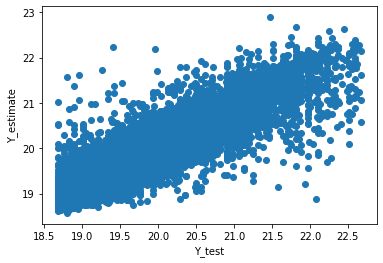

In [172]:
plt.scatter(Y_test, y_pred)
plt.xlabel("Y_test")
plt.ylabel("Y_estimate")
plt.show()

In [174]:
r2_score(Y_test, y_pred)

0.7983094242147101

### Lasso CV

In [202]:
alpha = [i/100 for i in range(1,400)]
model3 = sklearn.linear_model.LassoCV(n_alphas = 200, alphas = alpha , cv = 10)
model3.fit(X_train, Y_train)
prediction3 = model3.predict(X_test)
score_3 = model3.score(X_test, Y_test)

In [203]:
score_3

0.5587486115976593

## Ridge

In [215]:
from sklearn.linear_model import Ridge
# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, Y_train)
# get cross val scores
get_cv_scores(ridge)
[out]


CV Mean:  0.5992552674154563
STD:  0.004222296872466695




[<58360x9 sparse matrix of type '<class 'numpy.float64'>'
 	with 58360 stored elements in Compressed Sparse Row format>]

In [217]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

OSError: [Errno 12] Cannot allocate memory

## Linear

In [213]:
from sklearn.linear_model import LinearRegression
# Train model
lr = LinearRegression().fit(X_train, Y_train)
# get cross val scores
get_cv_scores(lr)

CV Mean:  0.599254763088335
STD:  0.0042243698192103




# Elastic-Net

In [222]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, Y_train)
# get cross val scores
get_cv_scores(elastic_net)
[out]
### CV Mean:  -0.05139208284143739
### STD:  0.07297997198698156
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

CV Mean:  0.008973441400177973
STD:  0.0014085668042525402




OSError: [Errno 12] Cannot allocate memory